first we need to train a parametric-umap network for each dataset... (5 datasets x 2 dimensions)
For umap-learn, UMAP AE, Param. UMAP, PCA
- load dataset
- load network
- compute reconstruction MSE
- count time

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [4]:
import numpy as np
import pickle
import pandas as pd
import time
from umap import UMAP

In [5]:
from tfumap.umap import tfUMAP
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
from tqdm.autonotebook import tqdm

In [7]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [8]:
output_dir = MODEL_DIR/'projections' 

In [9]:
reconstruction_acc_df = pd.DataFrame(columns = ['method_', 'dimensions', 'dataset', 'MSE', 'MAE', 'MedAE', 'R2'])

In [10]:
reconstruction_speed_df = pd.DataFrame(columns = ['method_', 'dimensions', 'dataset', 'embed_time', 'recon_time', 'speed', 'nex'])

### MNIST

In [11]:
dataset = 'cassins_dtw'
dims = (32,31,1)

##### load dataset

In [12]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

syllable_df = pd.read_pickle(DATA_DIR/'cassins'/ 'cassins.pickle')

#syllable_df= syllable_df[:1000]

syllable_df[:3]

top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)
top_labels

syllable_df = syllable_df[syllable_df.labels.isin(top_labels.columns)]

syllable_df[:3]

syllable_df = syllable_df.reset_index()

syllable_df['subset'] = 'train'
syllable_df.loc[:1000, 'subset'] = 'valid'
syllable_df.loc[1000:1999, 'subset'] = 'test'
#syllable_df.loc[:100, 'subset'] = 'valid'
#syllable_df.loc[100:199, 'subset'] = 'test'

specs = np.array(list(syllable_df.spectrogram.values))
specs = np.array([np.concatenate([np.zeros((32,1)), i], axis=1) for i in tqdm(specs)])
specs.shape

syllable_df['spectrogram'] = syllable_df['spectrogram'].astype('object')
syllable_df['spectrogram'] = list(specs)

np.shape(syllable_df['spectrogram'].values[0])

len(syllable_df)

Y_train = np.array(list(syllable_df.labels.values[syllable_df.subset == 'train']))
Y_valid = np.array(list(syllable_df.labels.values[syllable_df.subset == 'valid']))
Y_test = np.array(list(syllable_df.labels.values[syllable_df.subset == 'test']))

X_train = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'valid']))# / 255.
X_test = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'test'])) #/ 255.

X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Y_train = enc.fit_transform([[i] for i in Y_train]).astype('int').flatten()
X_test = X_test.reshape((len(X_test), 32,32,1))

In [13]:
len(X_test), len(X_train), len(X_valid)

(1000, 24984, 1000)

### AE 

##### 2 dims

In [14]:
load_loc = output_dir / dataset / 'autoencoder' 

In [15]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [16]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [17]:
decoder = tf.keras.models.load_model((load_loc / 'decoder').as_posix())
embedder.decoder = decoder

In [18]:
X_recon = tf.nn.relu(decoder(encoder(X_test))).numpy()
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

(array([886542.,  36382.,  24110.,  18634.,  14968.,  11975.,  11253.,
         10930.,   8046.,   1160.]),
 array([0.        , 0.09369057, 0.18738115, 0.28107172, 0.3747623 ,
        0.46845287, 0.56214345, 0.655834  , 0.7495246 , 0.84321517,
        0.93690574], dtype=float32),
 <a list of 10 Patch objects>)

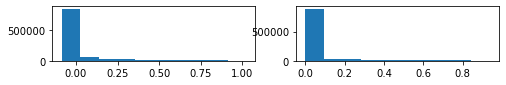

In [19]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=2, figsize=(8,1))
axs[0].hist(x_real.flatten())
axs[1].hist(x_recon.flatten())

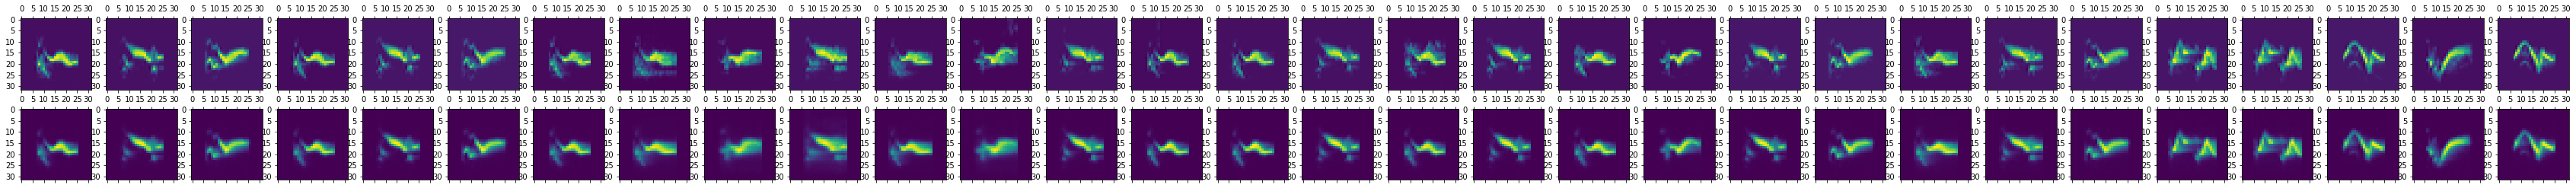

In [20]:
nex = 30
fig, axs = plt.subplots(nrows=2, ncols=nex, figsize=(nex*2, 2*2))
for i, (real, recon) in enumerate(zip(x_real[:nex], x_recon[:nex])):
    axs[0,i].matshow(real.reshape(32,32))
    axs[1,i].matshow(recon.reshape(32,32))

In [21]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

In [22]:
reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['AE', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,cassins_dtw,0.00275,0.019565,0.011422,-822391.803844


##### 64 dims

In [23]:
load_loc = output_dir / dataset / '64' / 'autoencoder' 

In [24]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [25]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [26]:
decoder = tf.keras.models.load_model((load_loc / 'decoder').as_posix())
embedder.decoder = decoder

In [27]:
X_recon = tf.nn.relu(decoder(encoder(X_test))).numpy()
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [28]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

In [29]:
reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['AE', 64, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,cassins_dtw,0.002750,0.019565,0.011422,-8.223918e+05
1,AE,64,cassins_dtw,0.002769,0.019662,0.011546,-4.694638e+07


### Network

##### 2 dims

In [30]:
load_loc = output_dir / dataset / 'recon-network' 

In [31]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "network",
    batch_size = 100,
    dims = dims
)

In [32]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [33]:
decoder = tf.keras.models.load_model((load_loc / 'decoder').as_posix())
embedder.decoder = decoder

In [34]:
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = encoder(X_test)
    end_time = time.monotonic()
    print("seconds: ", end_time - start_time)
    embed_time = end_time - start_time

    start_time = time.monotonic()
    x_test_recon = decoder(z_test)
    end_time = time.monotonic()
    print("seconds: ", end_time - start_time)
    recon_time = end_time - start_time
    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "network",
        2,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]

seconds:  0.16215487709268928
seconds:  0.2157849499490112
seconds:  0.011157450964674354
seconds:  0.010780819924548268
seconds:  0.013126287842169404
seconds:  0.010421079816296697
seconds:  0.010669447015970945
seconds:  0.009580615907907486
seconds:  0.012788418913260102
seconds:  0.009539835155010223
seconds:  0.010281366063281894
seconds:  0.007870147004723549
seconds:  0.011625695042312145
seconds:  0.009223975008353591
seconds:  0.014111995929852128
seconds:  0.009722379967570305
seconds:  0.011078458977863193
seconds:  0.009703608928248286
seconds:  0.009736220119521022
seconds:  0.009885814972221851



In [35]:
with tf.device('/CPU:0'):
    n_repeats = 10
    for i in tqdm(range(n_repeats)):
        start_time = time.monotonic()
        z_test = encoder(X_test)
        end_time = time.monotonic()
        print("seconds: ", end_time - start_time)
        embed_time = end_time - start_time

        start_time = time.monotonic()
        x_test_recon = decoder(z_test)
        end_time = time.monotonic()
        print("seconds: ", end_time - start_time)
        recon_time = end_time - start_time
        reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
            "network-cpu",
            2,
            dataset,
            embed_time,
            recon_time,
            embed_time + recon_time,
        len(X_test_flat)
        ]

seconds:  0.24321890017017722
seconds:  0.34983235807158053
seconds:  0.05737675982527435
seconds:  0.15158500312827528
seconds:  0.055605231085792184
seconds:  0.15391436009667814
seconds:  0.052811200032010674
seconds:  0.15395842120051384
seconds:  0.054727225098758936
seconds:  0.14749617502093315
seconds:  0.04846973507665098
seconds:  0.15293527208268642
seconds:  0.053355655865743756
seconds:  0.14776737405918539
seconds:  0.05564223206602037
seconds:  0.14486798993311822
seconds:  0.05523717007599771
seconds:  0.14817077503539622
seconds:  0.04938572086393833
seconds:  0.14625652902759612



In [36]:
X_recon = tf.nn.relu(decoder(encoder(X_test))).numpy()
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [37]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

In [38]:
reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['network', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,cassins_dtw,0.002750,0.019565,0.011422,-8.223918e+05
1,AE,64,cassins_dtw,0.002769,0.019662,0.011546,-4.694638e+07
2,network,2,cassins_dtw,0.002793,0.020141,0.012264,-6.232119e+05


##### 64 dims

In [39]:
load_loc = output_dir / dataset / '64' / 'recon-network' 

In [40]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [41]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [42]:
decoder = tf.keras.models.load_model((load_loc / 'decoder').as_posix())
embedder.decoder = decoder

In [43]:
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = encoder(X_test)
    end_time = time.monotonic()
    print("seconds: ", end_time - start_time)
    embed_time = end_time - start_time

    start_time = time.monotonic()
    x_test_recon = decoder(z_test)
    end_time = time.monotonic()
    print("seconds: ", end_time - start_time)
    recon_time = end_time - start_time
    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "network",
        64,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]

seconds:  0.1650000389199704
seconds:  0.2216386089567095
seconds:  0.011514100944623351
seconds:  0.009991776896640658
seconds:  0.011216473067179322
seconds:  0.009768842021003366
seconds:  0.013221238972619176
seconds:  0.00803740113042295
seconds:  0.013216701103374362
seconds:  0.009575445903465152
seconds:  0.011431347811594605
seconds:  0.009420271031558514
seconds:  0.01137280697003007
seconds:  0.009728501085191965
seconds:  0.012946761911734939
seconds:  0.009386020014062524
seconds:  0.012726415880024433
seconds:  0.008400622056797147
seconds:  0.011652314104139805
seconds:  0.008806584170088172



In [44]:
with tf.device("/CPU:0"):
    n_repeats = 10
    for i in tqdm(range(n_repeats)):
        start_time = time.monotonic()
        z_test = encoder(X_test)
        end_time = time.monotonic()
        print("seconds: ", end_time - start_time)
        embed_time = end_time - start_time

        start_time = time.monotonic()
        x_test_recon = decoder(z_test)
        end_time = time.monotonic()
        print("seconds: ", end_time - start_time)
        recon_time = end_time - start_time
        reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
            "network-cpu",
            64,
            dataset,
            embed_time,
            recon_time,
            embed_time + recon_time,
        len(X_test_flat)
        ]

seconds:  0.24758747592568398
seconds:  0.40502581698819995
seconds:  0.0652546479832381
seconds:  0.18678057589568198
seconds:  0.06939917686395347
seconds:  0.19699774007312953
seconds:  0.058007289189845324
seconds:  0.15962588414549828
seconds:  0.05507736490108073
seconds:  0.1543259909376502
seconds:  0.05129710608161986
seconds:  0.14937387802638113
seconds:  0.05178517987951636
seconds:  0.1562116350978613
seconds:  0.056707771960645914
seconds:  0.15530654089525342
seconds:  0.05155173409730196
seconds:  0.15878471988253295
seconds:  0.05061966716311872
seconds:  0.1477483429480344



In [45]:
reconstruction_speed_df

,method_,dimensions,dataset,embed_time,recon_time,speed,nex
0,network,2,cassins_dtw,0.162155,0.215785,0.377940,1000
1,network,2,cassins_dtw,0.011157,0.010781,0.021938,1000
2,network,2,cassins_dtw,0.013126,0.010421,0.023547,1000
3,network,2,cassins_dtw,0.010669,0.009581,0.020250,1000
4,network,2,cassins_dtw,0.012788,0.009540,0.022328,1000
5,network,2,cassins_dtw,0.010281,0.007870,0.018152,1000
6,network,2,cassins_dtw,0.011626,0.009224,0.020850,1000
7,network,2,cassins_dtw,0.014112,0.009722,0.023834,1000
8,network,2,cassins_dtw,0.011078,0.009704,0.020782,1000
9,network,2,cassins_dtw,0.009736,0.009886,0.019622,1000


In [46]:
X_recon = tf.nn.relu(decoder(encoder(X_test))).numpy()
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [47]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

In [48]:
reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['network', 64, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,cassins_dtw,0.002750,0.019565,0.011422,-8.223918e+05
1,AE,64,cassins_dtw,0.002769,0.019662,0.011546,-4.694638e+07
2,network,2,cassins_dtw,0.002793,0.020141,0.012264,-6.232119e+05
3,network,64,cassins_dtw,0.003355,0.022769,0.014031,-3.681100e+07


#### UMAP-learn

##### 2 dims

In [49]:
embedder = UMAP(n_components = 2, verbose=True)
z_umap = embedder.fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sat Jul 18 11:08:37 2020 Finding Nearest Neighbors
Sat Jul 18 11:08:37 2020 Building RP forest with 13 trees
Sat Jul 18 11:08:38 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Sat Jul 18 11:08:46 2020 Finished Nearest Neighbor Search
Sat Jul 18 11:08:49 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jul 18 11:09:07 2020 Finished embedding


In [50]:
x_test_samples= []
x_test_recon_samples= []
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = embedder.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    embed_time = end_time - start_time

    nex = 10 # it would take far too long to reconstruct the entire dataset
    samp_idx = np.random.randint(len(z_test),  size= nex)
    sample = np.array(z_test)[samp_idx]
    x_test_samples.append(samp_idx)
    start_time = time.monotonic()
    x_test_recon = embedder.inverse_transform(sample);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    recon_time = (end_time - start_time)*len(z_test)/nex

    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "umap-learn",
        2,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]
    x_test_recon_samples.append(x_test_recon)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  15.381913447985426
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  32.12861679191701
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  2.865735301049426
	completed  0  /  

In [51]:
x_recon = np.concatenate(x_test_recon_samples)

In [52]:
x_real = np.array(X_test_flat)[np.concatenate(x_test_samples)]

In [53]:

MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['umap-learn', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,cassins_dtw,0.002750,0.019565,0.011422,-8.223918e+05
1,AE,64,cassins_dtw,0.002769,0.019662,0.011546,-4.694638e+07
2,network,2,cassins_dtw,0.002793,0.020141,0.012264,-6.232119e+05
3,network,64,cassins_dtw,0.003355,0.022769,0.014031,-3.681100e+07
4,umap-learn,2,cassins_dtw,0.008452,0.036975,0.025322,-1.961244e+04


##### PCA

##### 2 dims


In [54]:
pca = PCA(n_components=2)
z = pca.fit_transform(X_train_flat)

In [55]:
X_test_flat.shape

(1000, 1024)

In [56]:
X_train_flat.shape

(24984, 1024)

In [57]:
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = pca.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    embed_time = end_time - start_time

    start_time = time.monotonic()
    x_test_recon = pca.inverse_transform(z_test);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    recon_time = (end_time - start_time)

    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "pca",
        2,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]

seconds:  0.003525342093780637
seconds:  0.008889846038073301
seconds:  0.00916808401234448
seconds:  0.03032684396021068
seconds:  0.016253077890723944
seconds:  0.030411555897444487
seconds:  0.005701713962480426
seconds:  0.009440422058105469
seconds:  0.01500247186049819
seconds:  0.027281515998765826
seconds:  0.016619299072772264
seconds:  0.020349296974018216
seconds:  0.010595346102491021
seconds:  0.039626921992748976
seconds:  0.004507770063355565
seconds:  0.008713190909475088
seconds:  0.004545110045000911
seconds:  0.008666198933497071
seconds:  0.01764831878244877
seconds:  0.021779047092422843



In [58]:
X_recon = pca.inverse_transform(pca.transform(X_test_flat))
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['pca', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,cassins_dtw,0.002750,0.019565,0.011422,-8.223918e+05
1,AE,64,cassins_dtw,0.002769,0.019662,0.011546,-4.694638e+07
2,network,2,cassins_dtw,0.002793,0.020141,0.012264,-6.232119e+05
3,network,64,cassins_dtw,0.003355,0.022769,0.014031,-3.681100e+07
4,umap-learn,2,cassins_dtw,0.008452,0.036975,0.025322,-1.961244e+04
5,pca,2,cassins_dtw,0.008243,0.038326,0.031248,-2.911929e+05


##### 64 dims

In [59]:
pca = PCA(n_components=64)
z = pca.fit_transform(X_train_flat)

In [60]:
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = pca.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    embed_time = end_time - start_time

    start_time = time.monotonic()
    x_test_recon = pca.inverse_transform(z_test);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    recon_time = (end_time - start_time)

    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "pca",
        64,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]

seconds:  0.005663213087245822
seconds:  0.00814468483440578
seconds:  0.005325173027813435
seconds:  0.008224006975069642
seconds:  0.00465951394289732
seconds:  0.008023201953619719
seconds:  0.004318963969126344
seconds:  0.007947488920763135
seconds:  0.0042796628549695015
seconds:  0.008888755924999714
seconds:  0.004373706178739667
seconds:  0.00773161300458014
seconds:  0.004272683057934046
seconds:  0.008275657892227173
seconds:  0.0043360351119190454
seconds:  0.007809215923771262
seconds:  0.004371806047856808
seconds:  0.007633039960637689
seconds:  0.00425855303183198
seconds:  0.00819732598029077



In [61]:
X_recon = pca.inverse_transform(pca.transform(X_test_flat))
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['pca', 64, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,cassins_dtw,0.002750,0.019565,0.011422,-8.223918e+05
1,AE,64,cassins_dtw,0.002769,0.019662,0.011546,-4.694638e+07
2,network,2,cassins_dtw,0.002793,0.020141,0.012264,-6.232119e+05
3,network,64,cassins_dtw,0.003355,0.022769,0.014031,-3.681100e+07
4,umap-learn,2,cassins_dtw,0.008452,0.036975,0.025322,-1.961244e+04
5,pca,2,cassins_dtw,0.008243,0.038326,0.031248,-2.911929e+05
6,pca,64,cassins_dtw,0.000769,0.012523,0.008722,-1.213795e+06


### Save

In [62]:
#save_loc = DATA_DIR / 'reconstruction_speed' / (dataset + '.pickle')
#ensure_dir(save_loc)
#reconstruction_speed_df.to_pickle(save_loc)

In [63]:
save_loc = DATA_DIR / 'reconstruction_acc' / (dataset + '.pickle')
ensure_dir(save_loc)
reconstruction_acc_df.to_pickle(save_loc)